# 0. Prep

In [1]:
% pylab inline

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from collections import Counter

corpus_path = ""

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Metadata contains columns "FILENAME" and "PUBL_DATE"
sample_df = pd.read_csv('sample_df.csv')

# 1. Create DTM

In [3]:
# Read Texts

sample_texts = []
for f_name in sample_df['FILENAME']:
    with open(corpus_path+f_name) as f_in:
        text = f_in.read()
    sample_texts.append(text)

In [4]:
# Create DTM with total word count

cv = CountVectorizer()
dtm_temp = cv.fit_transform(sample_texts).toarray()

In [5]:
# Select most frequent terms, totaling 95% of words in corpus

col_sums = sorted(dtm_temp.sum(axis = 0))[::-1]
total_tokens = sum(col_sums)
col_cumul = np.cumsum(col_sums)
vocab_size = np.where(col_cumul > total_tokens * 0.95)[0][0]

print("Vocab Size:", vocab_size)

Vocab Size: 12185


In [6]:
# DTM with 95% of words in corpus

cv = CountVectorizer(max_features=vocab_size)
dtm = cv.fit_transform(sample_texts).toarray()

# 2. Create Weight, PCA Functions

In [7]:
def weight_norm(dtm_, weight ='log-entropy'):
    
    valid_weights = ['norm', 'standard', 'tf-idf','log', 'log-entropy']
    if weight not in valid_weights:
        print("Invalid Weight. Must be in",valid_weights)
        return
    
    # Normalize
    dtm_norm = dtm_ / dtm_.sum(axis=1)[:,None]
    
    if weight == 'norm':
        return dtm_norm
    
    # Tf-Idf
    if weight == "tf-idf":
        col_df = (dtm > 0).sum(axis=0) # Document count per term
        dtm_tfidf = dtm * (np.log2( ( len(dtm) + 1 ) / (col_df + 1)  ) + 1) # Smooth Idf
        dtm_tfidf = dtm_tfidf / dtm_tfidf.sum(axis=1)[:,None] # Normalized
        return dtm_tfidf
    
    # Standard Units
    if weight == 'standard':
        col_mean, col_sd = dtm_norm.mean(axis = 0), dtm_norm.std(axis = 0) # Mean, SD of relative freq's
        dtm_strd = ( dtm_norm - col_mean ) / col_sd # Relative frequencies in standard units
        return dtm_strd

    # Log
    dtm_log = np.log2(dtm_ + 1)
    
    if weight == 'log':
        dtm_lognorm = dtm_log / np.linalg.norm(dtm_log, axis=1)[:,None] # l2-norm of log
        return dtm_lognorm

    # Log-Entropy
    dtm_prob = dtm_norm / dtm_norm.sum(axis=0) # Probability of document given term
    
    dtm_prob_nozero = dtm_prob[:] # Cumbersome transform zeros to ones, so that log doesn't throw error below
    dtm_prob_nozero[dtm_prob_nozero == 0] = 1
    
    dtm_ent = dtm_prob * np.log2(dtm_prob_nozero) # Entropy
    col_ent = 1 + dtm_ent.sum(axis=0) / log2(len(dtm)) # Column-wise; Scaled 0-1

    dtm_logent = dtm_log * col_ent # apply global weight
    dtm_logent = dtm_logent / np.linalg.norm(dtm_logent, axis=1)[:,None] # l2 normalized
    
    if weight == 'log-entropy':
        return dtm_logent

In [8]:
def pca_output(weighted_dtm_, ):
    pca = PCA(n_components=10)
    dtm_pca = pca.fit_transform(weighted_dtm_)

    print("Variance:",pca.explained_variance_ratio_[:2], "\n")

    xs, ys = dtm_pca[:,0], dtm_pca[:,1]
    
    figure(figsize=(7.5,7.5))
    for i in range(len(xs)):
        plt.plot(xs[i], ys[i], 'o', color = cm.cool(i/len(xs)), alpha = 0.8)

    lr = LinearRegression()
    lr.fit(dtm_pca[:,:2], sample_df['PUBL_DATE'])
    print("r2 (PUBL_DATE) =",lr.score(dtm_pca[:,:2], sample_df['PUBL_DATE']), "\n")
    
    feat_vec = pca.components_[0]
    feat_sort = np.array(cv.get_feature_names())[np.argsort(feat_vec)[::-1]]

    print("(PC 1) Pos. Terms:",feat_sort[:10])
    print("(PC 1) Neg. Terms:",feat_sort[-10:][::-1], "\n")
    
    feat_vec = pca.components_[1]
    feat_sort = np.array(cv.get_feature_names())[np.argsort(feat_vec)[::-1]]
    
    print("(PC 2) Pos. Terms:",feat_sort[:10])
    print("(PC 2) Neg. Terms:",feat_sort[-10:][::-1], "\n")
        
    plt.show()

# 3. Analysis

### Log-Entropy

In [9]:
wtd_dtm = weight_norm(dtm, weight = "log-entropy")

Variance: [ 0.02783686  0.01816933] 



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


r2 (PUBL_DATE) = 0.49363069743 

(PC 1) Pos. Terms: ['upon' 'morrow' 'presently' 'colour' 'thus' 'carriage' 'madame' 'ah'
 'exclaimed' '_i_']
(PC 1) Neg. Terms: ['guy' 'guys' 'gonna' 'yeah' 'cop' 'cops' 'phone' 'uh' 'okay' 'jack'] 

(PC 2) Pos. Terms: ['planet' 'ship' 'warriors' 'weapons' 'fleet' 'commander' 'controls'
 'meters' 'planets' 'galaxy']
(PC 2) Neg. Terms: ['mrs' 'aunt' 'george' 'ma' 'henry' 'papa' 'ain' 'lucy' 'joe' 'mr'] 



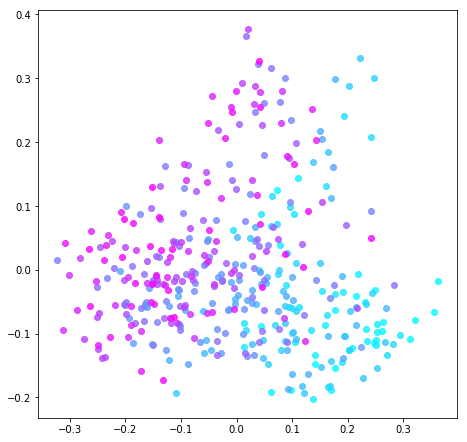

In [10]:
pca_output(wtd_dtm)

### Normalized (l1)

In [11]:
wtd_dtm = weight_norm(dtm, weight = "norm")

Variance: [ 0.25188108  0.10347834] 

r2 (PUBL_DATE) = 0.0737479709529 

(PC 1) Pos. Terms: ['the' 'of' 'his' 'and' 'he' 'in' 'from' 'their' 'by' 'they']
(PC 1) Neg. Terms: ['she' 'you' 'her' 'it' 'said' 'me' 'to' 'don' 'what' 'know'] 

(PC 2) Pos. Terms: ['her' 'she' 'of' 'had' 'as' 'to' 'in' 'with' 'which' 'the']
(PC 2) Neg. Terms: ['he' 'you' 'said' 'it' 'got' 'on' 'out' 'up' 'we' 'get'] 



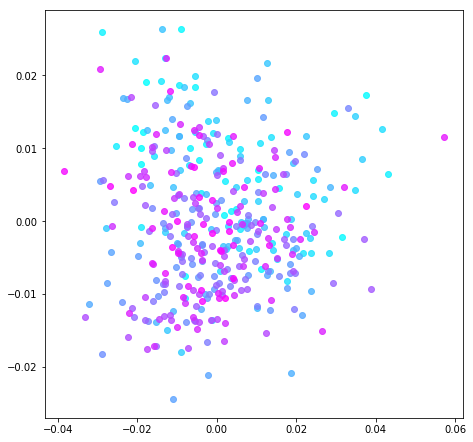

In [12]:
pca_output(wtd_dtm)

### Tf-Idf

In [13]:
wtd_dtm = weight_norm(dtm, weight = "tf-idf")

Variance: [ 0.05454807  0.02534312] 

r2 (PUBL_DATE) = 0.132988564525 

(PC 1) Pos. Terms: ['the' 'of' 'and' 'his' 'he' 'ellery' 'in' 'from' 'tarzan' 'their']
(PC 1) Neg. Terms: ['she' 'you' 'her' 'it' 'said' 'to' 'me' 'don' 'what' 'know'] 

(PC 2) Pos. Terms: ['her' 'she' 'of' 'had' 'to' 'as' 'letitia' 'in' 'with' 'was']
(PC 2) Neg. Terms: ['you' 'he' 'said' 'it' 'lennie' 'got' 'on' 'we' 'get' 'out'] 



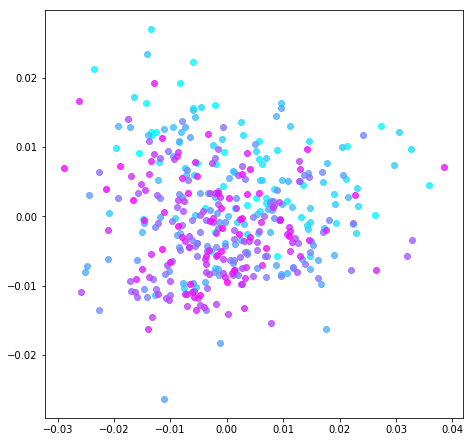

In [14]:
pca_output(wtd_dtm)

### Standard Units

In [15]:
wtd_dtm = weight_norm(dtm, weight = "standard")

Variance: [ 0.03295133  0.02164416] 

r2 (PUBL_DATE) = 0.30765717904 

(PC 1) Pos. Terms: ['of' 'such' 'by' 'whom' 'as' 'which' 'presence' 'present' 'thus' 'manner']
(PC 1) Neg. Terms: ['up' 'around' 'back' 'out' 'get' 'right' 'got' 'down' 'off' 'maybe'] 

(PC 2) Pos. Terms: ['the' 'through' 'feet' 'ground' 'from' 'above' 'edge' 'distance' 'below'
 'toward']
(PC 2) Neg. Terms: ['say' 'ask' 'know' 'think' 'dinner' 'to' 'anything' 'about' 'tell' 'any'] 



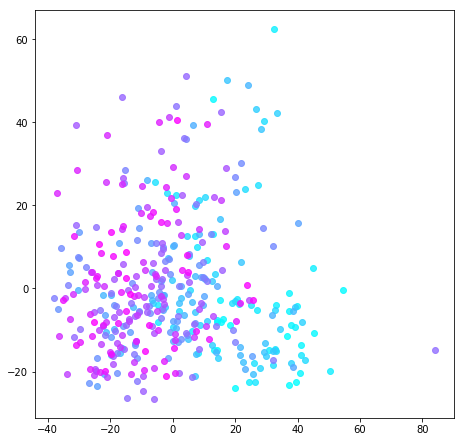

In [16]:
pca_output(wtd_dtm)

### Log

In [17]:
wtd_dtm = weight_norm(dtm, weight = "log")

Variance: [ 0.05927038  0.0481998 ] 

r2 (PUBL_DATE) = 0.478280567406 

(PC 1) Pos. Terms: ['upon' 'shall' 'thus' 'whom' 'indeed' 'replied' 'presence' 'greater'
 'however' 'manner']
(PC 1) Neg. Terms: ['maybe' 'guy' 'didn' 'phone' 'got' 'yeah' 'car' 'wasn' 'around' 'hell'] 

(PC 2) Pos. Terms: ['the' 'and' 'to' 'of' 'was' 'it' 'in' 'he' 'that' 'had']
(PC 2) Neg. Terms: ['someone' 'onto' 'okay' 'job' 'area' 'phone' 'hell' 'guy' 'center' 'damn'] 



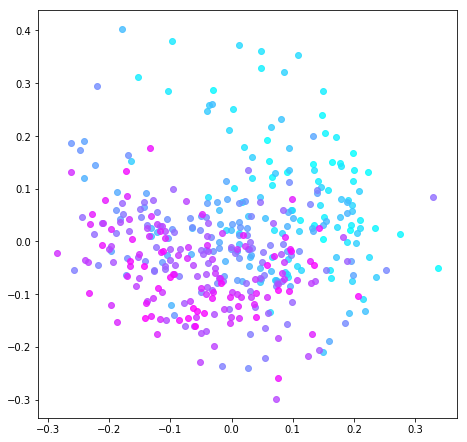

In [18]:
pca_output(wtd_dtm)